# 第2回 ベクトル空間モデル

この演習ページでは，ベクトル空間モデルに基づく情報検索モデルについて説明します．具体的には，文書から特徴ベクトルへの変換方法，TF-IDFの計算方法，コサイン類似度による文書ランキングについて，その実装例を説明します．第2回演習の最終目的は，ある与えられた文書コーパスに対して，TF-IDFで重み付けされた特徴ベクトルによる文書ランキングが実装できるようになることです．

## ライブラリ
この回の演習では，以下のライブラリを使用します．　
- [numpy, scipy](http://www.numpy.org/)
  + Pythonで科学技術計算を行うための基礎的なライブラリ．
- [gensim](https://radimrehurek.com/gensim/index.html)
  + トピックモデリング（LDA）やword2vecなどを手軽に利用するためのPythonライブラリ．
- [nltk (natural language toolkit)](http://www.nltk.org/)
  + 自然言語処理に関するpythonライブラリです．この演習ではストップワードのために用います．ほかにも，単語のステミングやトークナイズなどの機能をはじめ，品詞推定，依存関係分析など自然言語処理のあらゆるメソッドが用意されています．
- [pandas](http://pandas.pydata.org/)
  + pythonでデータ分析をするためのフレームワークです．この演習ではデータをプロットするために用いています．

## 第2回目の演習の内容
``h29iro/data/`` に `sample.corpus` というファイルを置いています． このファイルには改行区切りで3件の短い文書が保存されています．この演習では，このファイルに対してTF-IDFで重み付けされた特徴ベクトルを作成し，コサイン類似度によるランキングを行います．

## 1. 文書の読み込みとトークナイズ
まずは，`sample.corpus`を読み込み，各文書のBoW表現を抽出します．

In [1]:
import numpy as np
import gensim
from nltk.corpus import stopwords
import pandas as pd
np.set_printoptions(precision=4)

In [2]:
# 小数点3ケタまで表示
%precision 3

'%.3f'

In [3]:
with open("../data/sample.corpus", "r") as f:  #sample.corpusの読み込み
    text = f.read().strip().split("\n") #sample.corpusのテキストデータを取得し，それを改行で分割
text

['I live in kyoto and kyoto is a beautiful city',
 'kyoto was the captial of japan and is in kansai and kansai is in japan',
 'kyoto is in kansai and kyoto is historical city']

３件の文書があることが分かりますね．次に，文章をトークン（単語）に分割します．今回は簡単のため単純にスペース区切りによって単語に分割します．

In [4]:
raw_corpus = [d.lower().split() for d in text] #文章を小文字に変換して単語に分割する
print("d1=" , raw_corpus[0])
print("d2=" , raw_corpus[1])
print("d3=" , raw_corpus[2])

d1= ['i', 'live', 'in', 'kyoto', 'and', 'kyoto', 'is', 'a', 'beautiful', 'city']
d2= ['kyoto', 'was', 'the', 'captial', 'of', 'japan', 'and', 'is', 'in', 'kansai', 'and', 'kansai', 'is', 'in', 'japan']
d3= ['kyoto', 'is', 'in', 'kansai', 'and', 'kyoto', 'is', 'historical', 'city']


文が単語の集合に変換されました．しかし，この単語集合には "i" や "of" などのストップワードが含まれています．そこで，ストップワードを除去してみましょう．

ストップワードのリストはネットで探せば様々な種類が見つかります．ここでは，nltkのstopwordsモジュールを利用します．

In [5]:
# stopwords.words("english")に含まれていない単語のみ抽出
corpus = [list(filter(lambda word: word not in stopwords.words("english"), x)) for x in raw_corpus] 
print("d1=" , corpus[0])
print("d2=" , corpus[1])
print("d3=" , corpus[2])

d1= ['live', 'kyoto', 'kyoto', 'beautiful', 'city']
d2= ['kyoto', 'captial', 'japan', 'kansai', 'kansai', 'japan']
d3= ['kyoto', 'kansai', 'kyoto', 'historical', 'city']


## 2. 特徴ベクトルの生成
次に文書の特徴ベクトルを生成します．ここからの流れは，以下の通りになります．

1. 文書集合（corpus）から 単語->単語ID の辞書 (dictionary) を作成する．
2. 作成された辞書を基に，文書を (単語ID，出現回数）の集合 (id_corpus) として表現する．
3. id_corpusからTfidfModelを用いて，TF-IDFで重み付けされた特徴ベクトルを作成する．

まずは，文書集合（コーパス）から単語->単語ID の辞書 (dictionary) を作成します．


In [6]:
dictionary = gensim.corpora.Dictionary(corpus) #コーパスを与えて，単語->IDの辞書を作成する
dictionary.token2id #作成された辞書の中身

{'beautiful': 1,
 'captial': 6,
 'city': 2,
 'historical': 7,
 'japan': 5,
 'kansai': 4,
 'kyoto': 0,
 'live': 3}

このdictionaryを用いて，文書の単語をID化します．

In [7]:
id_corpus = [dictionary.doc2bow(document) for document in corpus]
id_corpus

[[(0, 2), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (4, 2), (5, 2), (6, 1)],
 [(0, 2), (2, 1), (4, 1), (7, 1)]]

作成されたid_corpusは，たとえば，1件目の文書は

In [8]:
id_corpus[0]

[(0, 2), (1, 1), (2, 1), (3, 1)]

という内容になっています．たとえば，(0,2)というデータは
```
単語ID0の単語が２回出現
```
という内容を表しています． つまり，単語の出現頻度(term frequency)のみで文書を特徴ベクトル化したことになります．なお，これをnumpyのベクトルとして抽出したければ，corpus2denseメソッドを用います．

In [9]:
tf_vectors = gensim.matutils.corpus2dense(id_corpus, len(dictionary)).T
print("d1=", tf_vectors[0])
print("d2=", tf_vectors[1])
print("d3=", tf_vectors[2])

d1= [ 2.  1.  1.  1.  0.  0.  0.  0.]
d2= [ 1.  0.  0.  0.  2.  2.  1.  0.]
d3= [ 2.  0.  1.  0.  1.  0.  0.  1.]


今回用意したコーパスは語彙数が8しかありませんが，実際のケースでは，この特徴ベクトルは非常に疎になることが容易に想像つくと思います．

さて，id_corpusからTFIDFで重み付けされた特徴ベクトルを得るには， models.TfidfModel メソッドを用います．

In [10]:
tfidf_model = gensim.models.TfidfModel(id_corpus, normalize=False) #normalize=Trueにすると，文書長によってtfを正規化する
tfidf_corpus = tfidf_model[id_corpus] #id_corpusをtfidfで重み付けされたものに変換

これでTF-IDFで重み付けされた特徴ベクトルが得られました．たとえば，1件目の文書$d_1$に対する特徴ベクトル${\mathbf d}_1$の中身を見てみます．

In [11]:
tfidf_corpus[0]

[(1, 1.585), (2, 0.585), (3, 1.585)]

TFIDFの値は，(単語ID，重み） として得られています．単語IDを実際の単語に変換するにはdictionaryを通します．

In [12]:
[(dictionary[x[0]], x[1]) for x in tfidf_corpus[0]]#dictionary[token_id]でアクセスすると実際の単語が返ってくる

[('beautiful', 1.585), ('city', 0.585), ('live', 1.585)]

同様に2件目の文書$d_2$についても見てみます．

In [13]:
doc2 = [(dictionary[x[0]], x[1]) for x in tfidf_corpus[1]]
doc2

[('kansai', 1.170), ('japan', 3.170), ('captial', 1.585)]

たとえば， 文書$d_{2}$における`japan`のTFIDF値が本当に正しいのか検証してみましょう．

$tfidf_{d_2, japan} = tf_{d_2, japan} \log \frac{N}{df_{japan}}$ ,

いま， $tf_{d_2, japan} = 2$, $N = 3$, $df_{japan}$ = 1 ですので，

$tfidf_{d_2, japan} = 2 \log 3 = 3.170$
となり，gensimで得られた結果と一致していることが分かります．

In [14]:
import math
2*math.log2(3) #2log3の計算方法

3.170

# 3. コサイン類似度
それでは，コサイン類似度による文書ランキングを行ってみましょう．

クエリと文書の類似度を測る前に，まずは文書同士のコサイン類似度を計算してみます． コサイン類似度の計算はgensimでも良いのですが，ここでは，いったんnumpyのベクトルを取得して，そのベクトルに対してコサイン類似度を計算してみます．

In [15]:
# 各文書のtfidfベクトルを取得
tfidf_vectors = gensim.matutils.corpus2dense(tfidf_corpus, len(dictionary)).T
print ("d1=", tfidf_vectors[0])
print ("d2=", tfidf_vectors[1])
print ("d3=", tfidf_vectors[2])

d1= [ 0.     1.585  0.585  1.585  0.     0.     0.     0.   ]
d2= [ 0.     0.     0.     0.     1.17   3.17   1.585  0.   ]
d3= [ 0.     0.     0.585  0.     0.585  0.     0.     1.585]


In [16]:
# コサイン類似度を計算する関数を用意
from scipy.spatial.distance import cosine
def cosine_sim(v1, v2):
    #scipyのcosineは類似度ではなく距離関数のため， 1-コサイン距離　とすることで，コサイン類似度に変換する
    return 1.0 - cosine(v1, v2) 

In [17]:
# 各文書間のコサイン類似度を計算してみる
print ("sim(d1, d2)=", cosine_sim(tfidf_vectors[0], tfidf_vectors[1]))
print ("sim(d2, d3)=", cosine_sim(tfidf_vectors[1], tfidf_vectors[2]))
print ("sim(d1, d3)=", cosine_sim(tfidf_vectors[0], tfidf_vectors[2]))

sim(d1, d2)= 0.0
sim(d2, d3)= 0.102562095083
sim(d1, d3)= 0.082618937993


それでは，クエリを特徴ベクトルに変換し，クエリと文書のコサイン類似度を求めていきましょう．

In [18]:
q = {"kansai", "japan"}
tfidf_q = tfidf_model[dictionary.doc2bow(q)]  #クエリをtfidfベクトルに変換
query_vector = gensim.matutils.corpus2dense([tfidf_q], len(dictionary)).T[0] #numpyのベクトルに変換
print ("q=", query_vector)

q= [ 0.     0.     0.     0.     0.585  1.585  0.     0.   ]


In [19]:
print([(dictionary[x[0]], x[1]) for x in tfidf_q])

[('kansai', 0.5849625007211562), ('japan', 1.5849625007211563)]


In [20]:
print ("sim(q, d1) = ", cosine_sim(query_vector, tfidf_vectors[0]))
print ("sim(q, d2) = ", cosine_sim(query_vector, tfidf_vectors[1]))
print ("sim(q, d3) = ", cosine_sim(query_vector, tfidf_vectors[2]))

sim(q, d1) =  0.0
sim(q, d2) =  0.905346644389
sim(q, d3) =  0.113284893168


この結果から，q={"kansai", "japan"} というクエリに対しては，$d_2,d_3, d_1$の順でランク付けされることが分かります．

## 4. ベクトル空間の可視化

最後に，得られた特徴ベクトルを可視化してみましょう．特徴ベクトルそのものは多次元（今回の場合は8次元）ですが，これを次元削減の手法を使って，2次元空間に射影してみます．今回は，`LSI`（Latent Semantic Indexing)という手法を用いて，特徴ベクトルを2次元空間に落とし込みます．LSIについては，講義で触れるかもしれません（講義の進み方次第）．

In [21]:
import matplotlib.pylab as plt

In [22]:
%matplotlib inline

In [23]:
# LSIにより特徴ベクトルを2次元に落とし込む
lsi = gensim.models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=2)
lsi_corpus = lsi[tfidf_corpus]
lsi_vectors = gensim.matutils.corpus2dense(lsi_corpus, 2).T
print("d1=", lsi_vectors[0])
print("d2=", lsi_vectors[1])
print("d3=", lsi_vectors[2])
query_lsi_corpus = lsi[[tfidf_q]] 
query_lsi_vector = gensim.matutils.corpus2dense(query_lsi_corpus, 2).T[0]
print ("q=", query_lsi_vector)

d1= [-0.009  2.302]
d2= [-3.73  -0.028]
d3= [-0.237  0.346]
q= [-1.53  -0.007]


In [24]:
# 散布図にプロットするため，DataFrameに変換
axis_names = ["z1", "z2"]
doc_names = ["d1", "d2", "d3", "q"]
df = pd.DataFrame(np.r_[lsi_vectors, [query_lsi_vector]], 
                  columns=axis_names, index=doc_names) # np.r_ は行列同士の連結
df

,z1,z2
d1,-0.009431,2.301599
d2,-3.730471,-0.027818
d3,-0.237208,0.345971
q,-1.529893,-0.007460


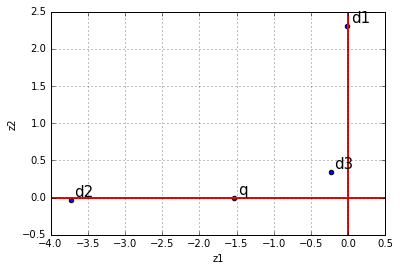

In [25]:
# 散布図をプロット
fig, ax = plt.subplots()
df.plot.scatter(x="z1", y="z2", ax=ax)
ax.axvline(x=0, lw=2, color='red') #x軸とy軸に線を引く
ax.axhline(y=0, lw=2, color='red') 
ax.grid(True)
for k, v in df.iterrows():
    ax.annotate(k, xy=(v[0]+0.05,v[1]+0.05),size=15) #データ点にラベル名を付与

この図を見てみると，やはりクエリ$q$と文書$d_2$はほぼ同じ方向（つまり，コサイン類似度が１に近い）であることがわかり， $q$と$d_1$の角度はほぼ直角（つまりコサイン類似度が0）であることがわかります．

# 演習課題

工事中